<a class="anchor" id="0"></a>

# **SARIMA Model for Time Series Forecasting: COVID-19 in Canada**

**Author:** Stephen Prudente  
**Start Date:** 20th January, 2021

**Purpose:** The objective of this notebook is to explore using SARIMA Time Series Forecasting on a COVID-19 dataset from the Canadian Government open datasets repository to predict COVID-19 positive cases. SARIMA (Seasonal Autoregressive Integrated Moving Average).

**Dataset:** The dataset being used comes from the Canadian Government open data portal. The variable being focused on is the number of COVID-19 tests done as it's shown to have a positive correlation towards COVID-19 positive cases as well as being statistically significant. Therefore, the variable 'numteststoday' is the main focus of this analysis.

## Table of contents
1. [Importing Libraries](#Import-Libraries)
2. [Read Data](#read-data)
3. [Data Preperation](#data-preperation)
4. [Data Visualizations](#data-visualizations)  
5. [Feature Engineering](#feature-engineering)
6. [Training The Data](#training-the-data)
7. [Modeling The Data](#modelling-the-data-a-class)
8. [Future Predictions](#future-predictions)

## Importing Libraries  <a name="log"></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pmdarima as pm
from pmdarima.model_selection import train_test_split
from pmdarima.arima import auto_arima
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt
import itertools
import warnings
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_log_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
plt.style.use('ggplot')
%matplotlib inline

# Read Data  <a name="log"></a>

- Now, we will import the dataset in CSV format from a Url and show the top 5 rows of the dataset.

In [2]:
df = pd.read_csv (r'https://health-infobase.canada.ca/src/data/covidLive/covid19-download.csv')
print ('Shape of data', df.shape)
df.head(5)

Shape of data (11187, 40)


,pruid,prname,prnameFR,date,update,numconf,numprob,numdeaths,numtotal,numtested,...,ratedeaths_last14,numtotal_last7,ratetotal_last7,numdeaths_last7,ratedeaths_last7,avgtotal_last7,avgincidence_last7,avgdeaths_last7,avgratedeaths_last7,raterecovered
0,35,Ontario,Ontario,2020-01-31,NaN,3,0.0,0,3,0.0,...,0.0,0,0.00,0,0.0,0.00,0.00,0.0,0.0,0.0
1,59,British Columbia,Colombie-Britannique,2020-01-31,NaN,1,0.0,0,1,0.0,...,0.0,0,0.00,0,0.0,0.00,0.00,0.0,0.0,0.0
2,1,Canada,Canada,2020-01-31,NaN,4,0.0,0,4,0.0,...,0.0,0,0.00,0,0.0,0.00,0.00,0.0,0.0,0.0
3,35,Ontario,Ontario,2020-02-08,NaN,3,0.0,0,3,0.0,...,0.0,0,0.00,0,0.0,0.00,0.00,0.0,0.0,0.0
4,59,British Columbia,Colombie-Britannique,2020-02-08,NaN,4,0.0,0,4,0.0,...,0.0,3,0.06,0,0.0,0.43,0.01,0.0,0.0,0.0


- Viewing if any of the fields in the Canada dataset contains a null value which shows by a boolean value.

In [3]:
df.isna().any()

pruid                  False
prname                 False
prnameFR               False
date                   False
update                  True
numconf                False
numprob                 True
numdeaths              False
numtotal               False
numtested               True
numtests               False
numrecover             False
percentrecover         False
ratetested              True
ratetests               True
numtoday               False
percentoday            False
ratetotal               True
ratedeaths              True
numdeathstoday         False
percentdeath           False
numtestedtoday          True
numteststoday          False
numrecoveredtoday      False
percentactive          False
numactive              False
rateactive              True
numtotal_last14        False
ratetotal_last14        True
numdeaths_last14       False
ratedeaths_last14       True
numtotal_last7         False
ratetotal_last7         True
numdeaths_last7        False
ratedeaths_las

- Checking for duplicates in the entire dataset.

In [4]:
df.duplicated()

0        False
1        False
2        False
3        False
4        False
         ...  
11182    False
11183    False
11184    False
11185    False
11186    False
Length: 11187, dtype: bool

- Descriptive statistics of the main dataset.

In [5]:
df_describe = df.describe()

- Creating a correlation dataframe for each dataset to show the strength of influence of each variable to one another.

In [6]:
correlation = df.corr()

- Viewing the correlation of each dataset.

In [7]:
df.corr()

,pruid,update,numconf,numprob,numdeaths,numtotal,numtested,numtests,numrecover,percentrecover,...,ratedeaths_last14,numtotal_last7,ratetotal_last7,numdeaths_last7,ratedeaths_last7,avgtotal_last7,avgincidence_last7,avgdeaths_last7,avgratedeaths_last7,raterecovered
pruid,1.000000e+00,-0.074600,-0.282221,-0.038164,-0.362827,-0.282222,-0.190802,-0.318616,-0.279072,-0.004650,...,-0.067231,-0.211743,-0.012559,-0.283676,-0.063813,-0.211743,-0.012558,-0.283274,-0.063964,-0.005626
update,-7.460025e-02,1.000000,0.128745,NaN,0.152161,0.128745,0.069222,0.151662,0.128180,-0.053117,...,0.085962,0.104289,-0.014786,0.148438,0.085874,0.104289,-0.014784,0.147857,0.086018,0.095801
numconf,-2.822208e-01,0.128745,1.000000,-0.015208,0.930929,1.000000,0.090026,0.974628,0.998959,0.137767,...,0.166402,0.667785,0.101023,0.510997,0.151691,0.667785,0.101025,0.511033,0.152096,0.366714
numprob,-3.816406e-02,NaN,-0.015208,1.000000,-0.007818,-0.015167,0.004979,-0.015799,-0.016091,-0.092384,...,-0.010516,-0.005832,-0.017185,0.025476,-0.009796,-0.005832,-0.017185,0.025757,-0.009628,-0.033403
numdeaths,-3.628267e-01,0.152161,0.930929,-0.007818,1.000000,0.930929,0.240019,0.964017,0.929874,0.133602,...,0.182309,0.611272,0.058445,0.563060,0.163937,0.611272,0.058446,0.563122,0.164312,0.379075
numtotal,-2.822224e-01,0.128745,1.000000,-0.015167,0.930929,1.000000,0.090026,0.974628,0.998959,0.137763,...,0.166402,0.667785,0.101023,0.510998,0.151691,0.667785,0.101024,0.511035,0.152096,0.366714
numtested,-1.908019e-01,0.069222,0.090026,0.004979,0.240019,0.090026,1.000000,0.153748,0.073359,0.002101,...,0.208285,0.219317,0.014835,0.533208,0.201898,0.219317,0.014836,0.533177,0.202116,-0.064633
numtests,-3.186156e-01,0.151662,0.974628,-0.015799,0.964017,0.974628,0.153748,1.000000,0.974757,0.147545,...,0.134283,0.649795,0.079171,0.500907,0.123122,0.649795,0.079172,0.500927,0.123485,0.387766
numrecover,-2.790720e-01,0.128180,0.998959,-0.016091,0.929874,0.998959,0.073359,0.974757,1.000000,0.142861,...,0.156562,0.635292,0.090420,0.492972,0.141387,0.635292,0.090421,0.493017,0.141771,0.365282
percentrecover,-4.649721e-03,-0.053117,0.137767,-0.092384,0.133602,0.137763,0.002101,0.147545,0.142861,1.000000,...,-0.050576,0.040260,-0.011119,-0.068839,-0.065519,0.040260,-0.011118,-0.068637,-0.065591,0.236415


# Data Preperation  <a name="log"></a>

- Creating a new dataframe that only contains rows that have the value of 'Canada' in the 'prname' field. The rows that contain this value equal the total of all the provinces values, therefore this dataset will represent the entire country.

In [8]:
df_Canada = df[df['prname'].str.contains('Canada')]
print(df)

       pruid                  prname                   prnameFR        date  \
0         35                 Ontario                    Ontario  2020-01-31   
1         59        British Columbia       Colombie-Britannique  2020-01-31   
2          1                  Canada                     Canada  2020-01-31   
3         35                 Ontario                    Ontario  2020-02-08   
4         59        British Columbia       Colombie-Britannique  2020-02-08   
...      ...                     ...                        ...         ...   
11182     60                   Yukon                      Yukon  2022-03-22   
11183     61   Northwest Territories  Territoires du Nord-Ouest  2022-03-22   
11184     62                 Nunavut                    Nunavut  2022-03-22   
11185     99  Repatriated travellers        Voyageurs rapatriés  2022-03-22   
11186      1                  Canada                     Canada  2022-03-22   

       update  numconf  numprob  numdeaths  numtota

- Creating a data subset that will be used in the modeling containing the following columns: 'prname' (Province Name) & 'numconf' (Number Confirmed). The dataset this originates is the one that contains only rows with the value 'Canada'. This results in this dataset containing the date per case(s), the number of tests done each day for Canada.

In [9]:
df_SARIMA = df_Canada[['date','prname','numteststoday']]
print(df_SARIMA)

             date  prname  numteststoday
2      2020-01-31  Canada              0
5      2020-02-08  Canada             63
8      2020-02-16  Canada             46
11     2020-02-21  Canada             57
14     2020-02-24  Canada             46
...           ...     ...            ...
11126  2022-03-18  Canada          43149
11141  2022-03-19  Canada          28378
11156  2022-03-20  Canada           2945
11171  2022-03-21  Canada          76418
11186  2022-03-22  Canada          27576

[758 rows x 3 columns]


# Data Visualizations  <a name="log"></a>

- Line graph from the dataset using the numconf (Number Confirmed) and the date (Index).

<AxesSubplot:>

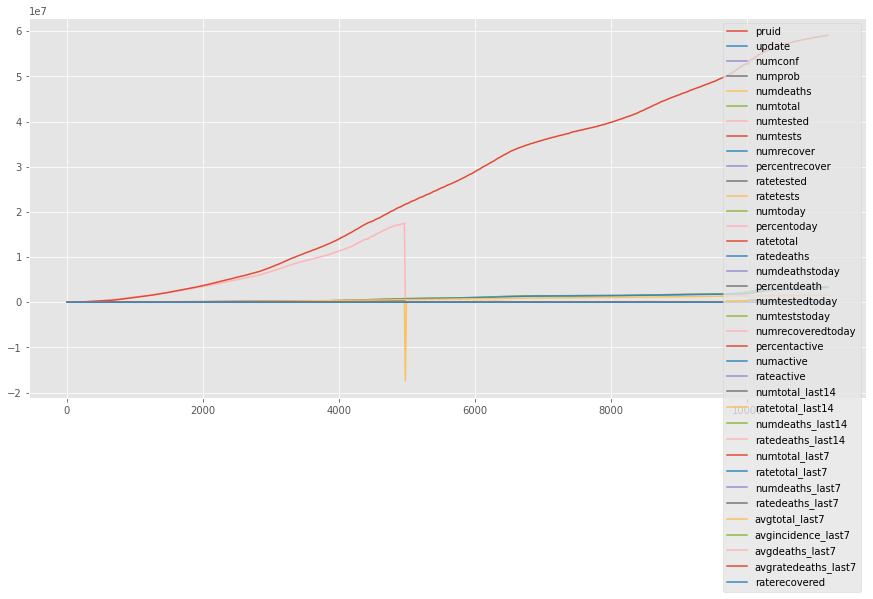

In [10]:
from pylab import rcParams
rcParams['figure.figsize'] = 15, 7
df_Canada.plot()

<AxesSubplot:>

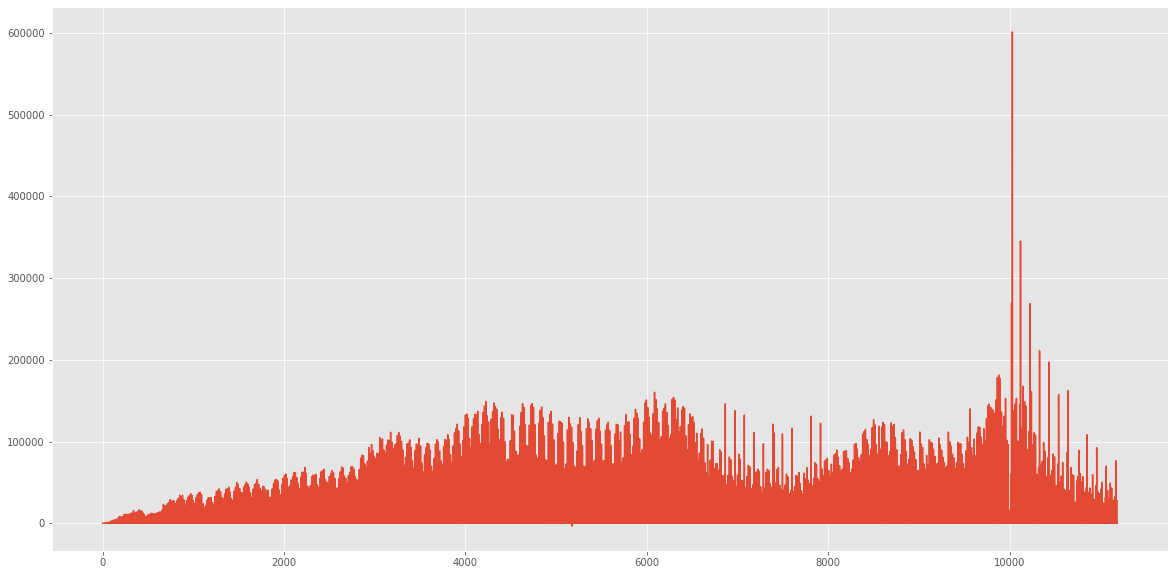

In [11]:
df['numteststoday'].plot(figsize=(20,10))

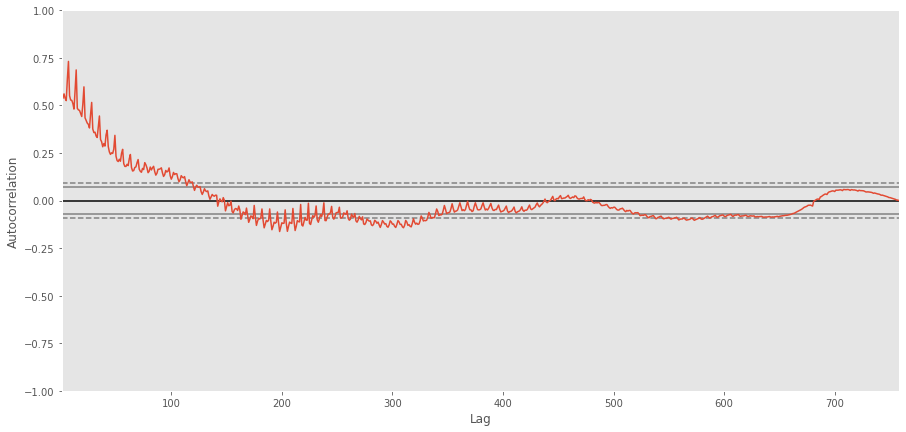

In [12]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df_Canada['numteststoday'])
plt.show()

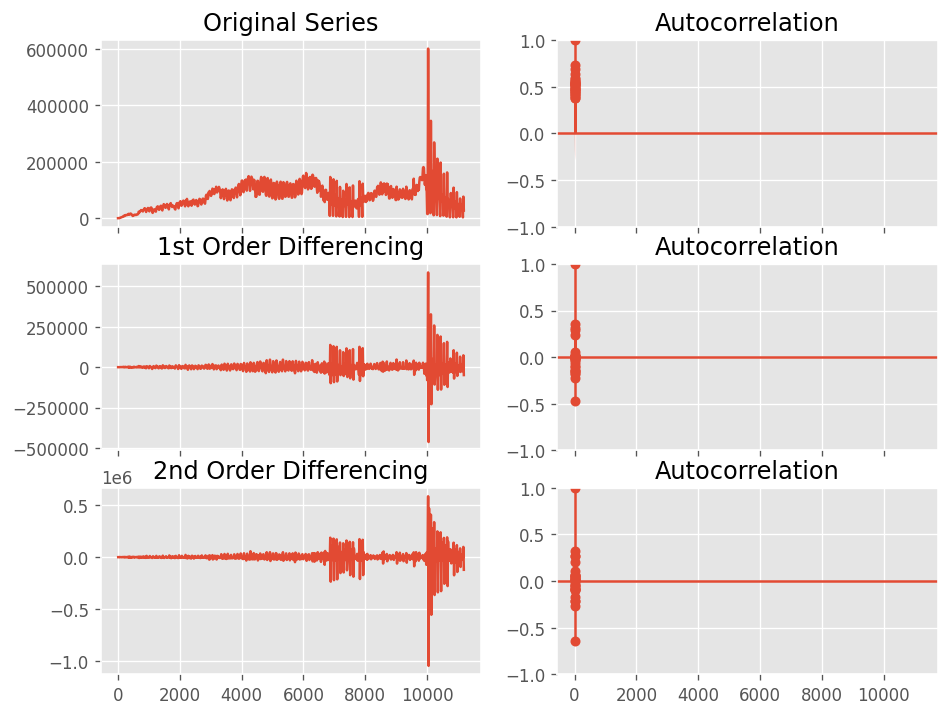

In [13]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})


# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df_Canada.numteststoday); axes[0, 0].set_title('Original Series')
plot_acf(df_Canada.numteststoday, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df_Canada.numteststoday.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df_Canada.numteststoday.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df_Canada.numteststoday.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df_Canada.numteststoday.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

# Feature Engineering  <a name="log"></a>

In [14]:
from statsmodels.tsa.stattools import adfuller

In [15]:
test_result=adfuller(df_Canada['numteststoday'])

In [16]:
from statsmodels.tsa.stattools import adfuller

def ad_test(df_Canada):
     dftest = adfuller(df_Canada, autolag = 'AIC')
     print("1. ADF : ",dftest[0])
     print("2. P-Value : ", dftest[1])
     print("3. Num Of Lags : ", dftest[2])
     print("4. Num Of Observations Used For ADF Regression and Critical Value Calculation :",      dftest[3])
     print("5. Critical Values :")
     for key, val in dftest[4].items():
         print("\t",key, ": ", val)

- First Difference and Seasonal Difference

In [17]:
df_Canada['numteststoday First Difference'] = df_Canada['numteststoday'] - df_Canada['numteststoday'].shift(1)
df_Canada['Seasonal First Difference']=df_Canada['numteststoday']-df_Canada['numteststoday'].shift(12)
df_Canada.head()

C:\Users\prude\AppData\Local\Temp\ipykernel_34712\3249552013.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Canada['numteststoday First Difference'] = df_Canada['numteststoday'] - df_Canada['numteststoday'].shift(1)
C:\Users\prude\AppData\Local\Temp\ipykernel_34712\3249552013.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Canada['Seasonal First Difference']=df_Canada['numteststoday']-df_Canada['numteststoday'].shift(12)


,pruid,prname,prnameFR,date,update,numconf,numprob,numdeaths,numtotal,numtested,...,ratetotal_last7,numdeaths_last7,ratedeaths_last7,avgtotal_last7,avgincidence_last7,avgdeaths_last7,avgratedeaths_last7,raterecovered,numteststoday First Difference,Seasonal First Difference
2,1,Canada,Canada,2020-01-31,NaN,4,0.0,0,4,0.0,...,0.00,0,0.0,0.00,0.0,0.0,0.0,0.0,NaN,NaN
5,1,Canada,Canada,2020-02-08,NaN,7,0.0,0,7,0.0,...,0.01,0,0.0,0.43,0.0,0.0,0.0,0.0,63.0,NaN
8,1,Canada,Canada,2020-02-16,NaN,8,0.0,0,8,0.0,...,0.01,0,0.0,0.57,0.0,0.0,0.0,0.0,-17.0,NaN
11,1,Canada,Canada,2020-02-21,NaN,9,0.0,0,9,0.0,...,0.01,0,0.0,0.71,0.0,0.0,0.0,0.0,11.0,NaN
14,1,Canada,Canada,2020-02-24,NaN,10,0.0,0,10,0.0,...,0.02,0,0.0,0.86,0.0,0.0,0.0,0.0,-11.0,NaN


- For non-seasonal data
#p=1, d=1, q=0 or 1


<AxesSubplot:>

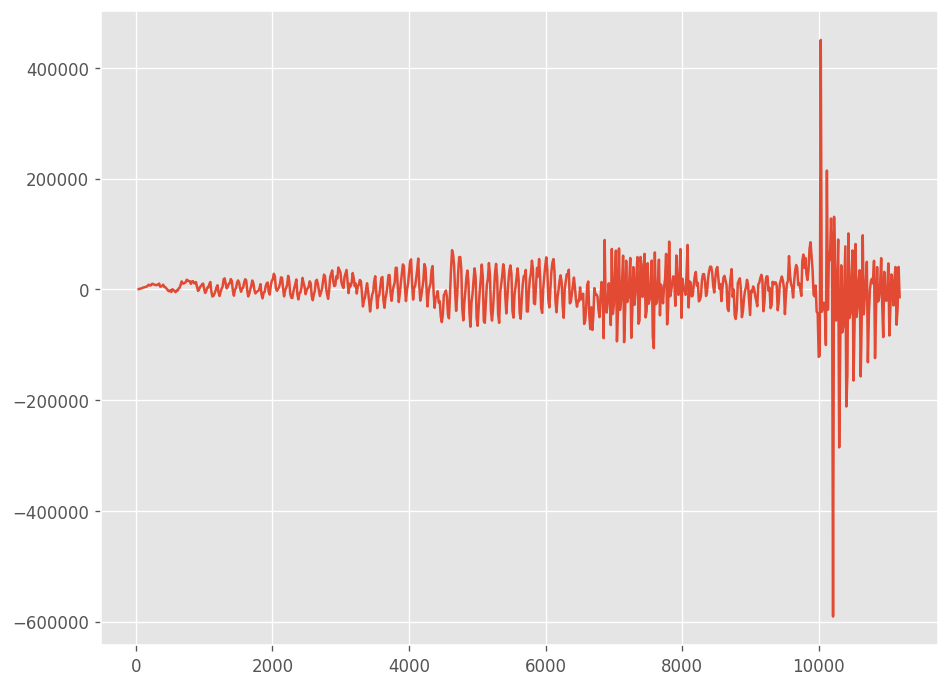

In [18]:
df_Canada['Seasonal First Difference'].plot()

c:\Users\prude\OneDrive\Desktop\Project\venv\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


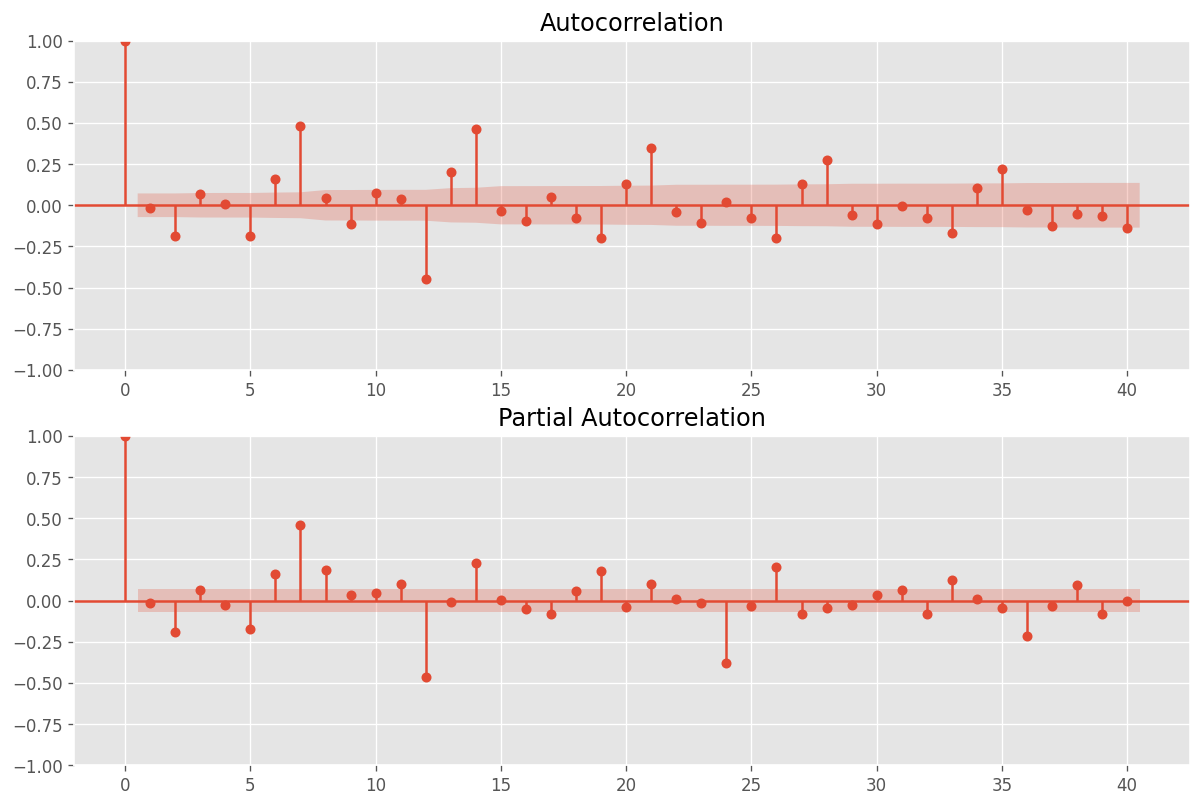

In [19]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_Canada['Seasonal First Difference'].dropna(),lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_Canada['Seasonal First Difference'].dropna(),lags=40,ax=ax2)

- Determining if the p-value is greater than the significance level (0.05).

In [20]:
ad_test(df['numteststoday'])

1. ADF :  -7.026367843343041
2. P-Value :  6.349212946771595e-10
3. Num Of Lags :  40
4. Num Of Observations Used For ADF Regression and Critical Value Calculation : 11146
5. Critical Values :
	 1% :  -3.4309368299524947
	 5% :  -2.8617993468678913
	 10% :  -2.5669080452196895


In [21]:
best_model = SARIMAX(df_Canada['numteststoday'], order=(2, 1, 2), seasonal_order=(2, 1, 2, 12)).fit(dis=-1)
print(best_model.summary())

c:\Users\prude\OneDrive\Desktop\Project\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\prude\OneDrive\Desktop\Project\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\prude\OneDrive\Desktop\Project\venv\lib\site-packages\statsmodels\base\optimizer.py:17: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score. The list of unsupported keyword arguments passed include: dis. After release 0.14, this will raise.
  warnings.warn(
c:\Users\prude\OneDrive\Desktop\Project\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: M

                                     SARIMAX Results                                      
Dep. Variable:                      numteststoday   No. Observations:                  758
Model:             SARIMAX(2, 1, 2)x(2, 1, 2, 12)   Log Likelihood               -8884.261
Date:                            Wed, 23 Mar 2022   AIC                          17786.522
Time:                                    23:39:30   BIC                          17828.042
Sample:                                         0   HQIC                         17802.525
                                            - 758                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7347      0.068     10.798      0.000       0.601       0.868
ar.L2         -0.1387      0.083   

# Training The Data  <a name="log"></a>

- Split the dataset into training and testing. Validate the set to calculate the R-Squared score and the mean asbolte percentage error.

In [22]:
#divide into train and validation set to calculate R-squared score and mean absolute percentage error 
train = df_Canada[:int(0.85*(len(df_Canada)))]
test = df_Canada[int(0.85*(len(df_Canada))):]
start=len(train)
end=len(train)+len(test)-1
predictions = best_model.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA Predictions')
evaluation_results = pd.DataFrame({'r2_score': r2_score(test['numteststoday'], predictions)}, index=[0])
evaluation_results['mean_absolute_error'] = mean_absolute_error(test['numteststoday'], predictions)
evaluation_results['mean_squared_error'] = mean_squared_error(test['numteststoday'], predictions)
evaluation_results['root_mean_squared_error'] = np.sqrt(mean_squared_error(test['numteststoday'], predictions))
evaluation_results['mean_absolute_percentage_error'] = np.mean(np.abs(predictions - test['numteststoday'])
                                                               /np.abs(test['numteststoday']))*100 
evaluation_results

,r2_score,mean_absolute_error,mean_squared_error,root_mean_squared_error,mean_absolute_percentage_error
0,0.267876,38008.775155,4.139068e+09,64335.586958,158.395134


- Make predictions on Test Set

In [23]:
start=len(train)
end=len(train)+len(test)-1
pred=best_model.predict(start=start,end=end,typ='levels')
print(pred)

9491     84960.243739
9506     77388.825145
9521     84216.570763
9536     86782.026055
9551     86659.405740
             ...     
11126    42010.024652
11141    27624.151681
11156    41358.589790
11171    35464.544632
11186    38737.518242
Name: predicted_mean, Length: 114, dtype: float64


<AxesSubplot:>

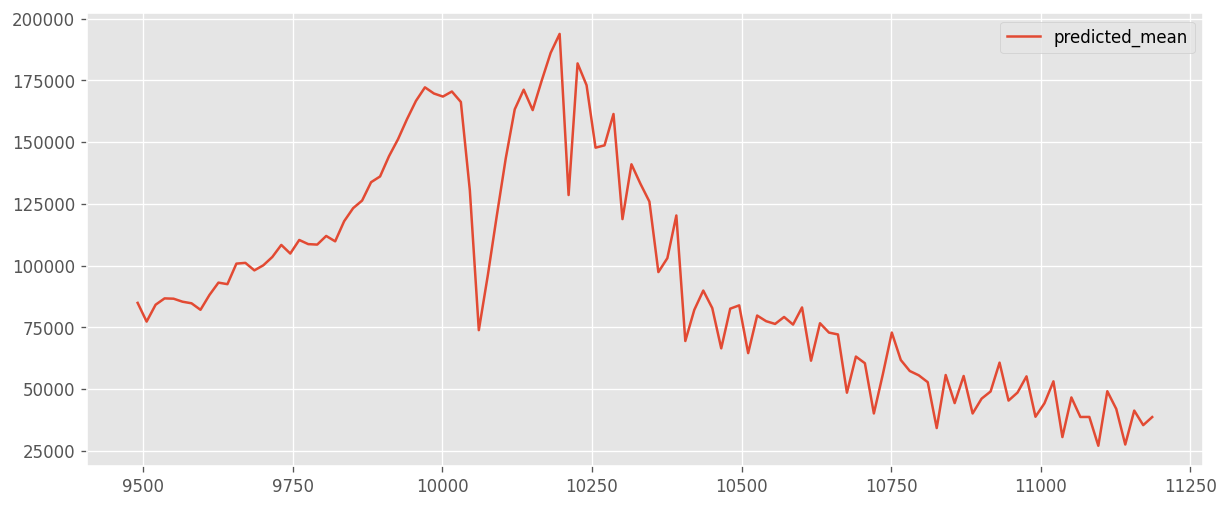

In [24]:
pred.plot(figsize=(12,5),legend=True)

<AxesSubplot:>

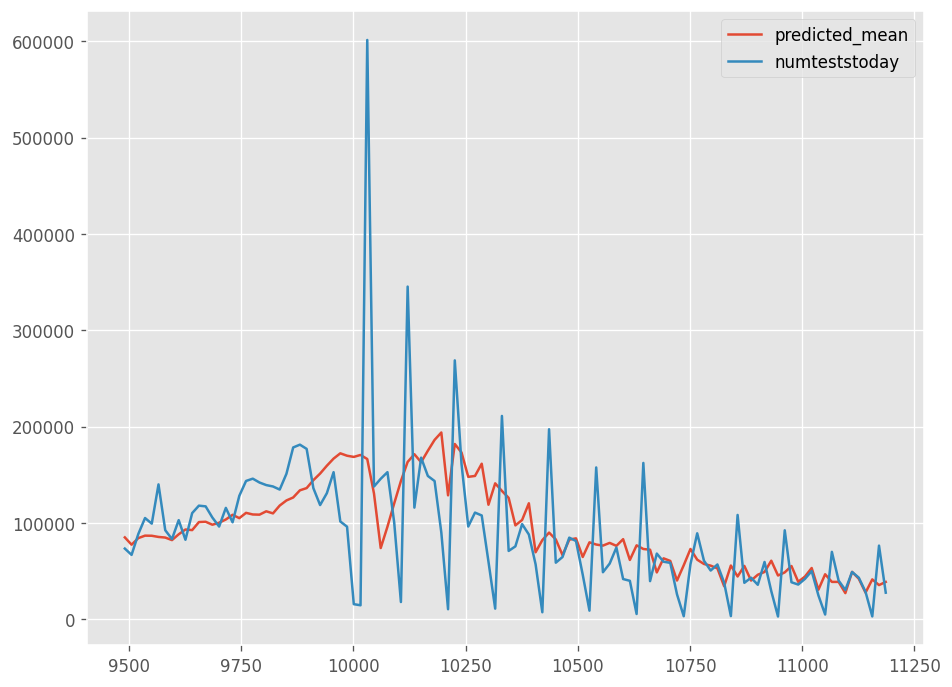

In [25]:
pred.plot(legend=True)
test['numteststoday'].plot(legend=True)

In [26]:
test['numteststoday'].mean()

91545.48245614035

In [27]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(pred,test['numteststoday']))
print(rmse)

64335.586958044725


# Modelling The Data  <a name="log"></a>

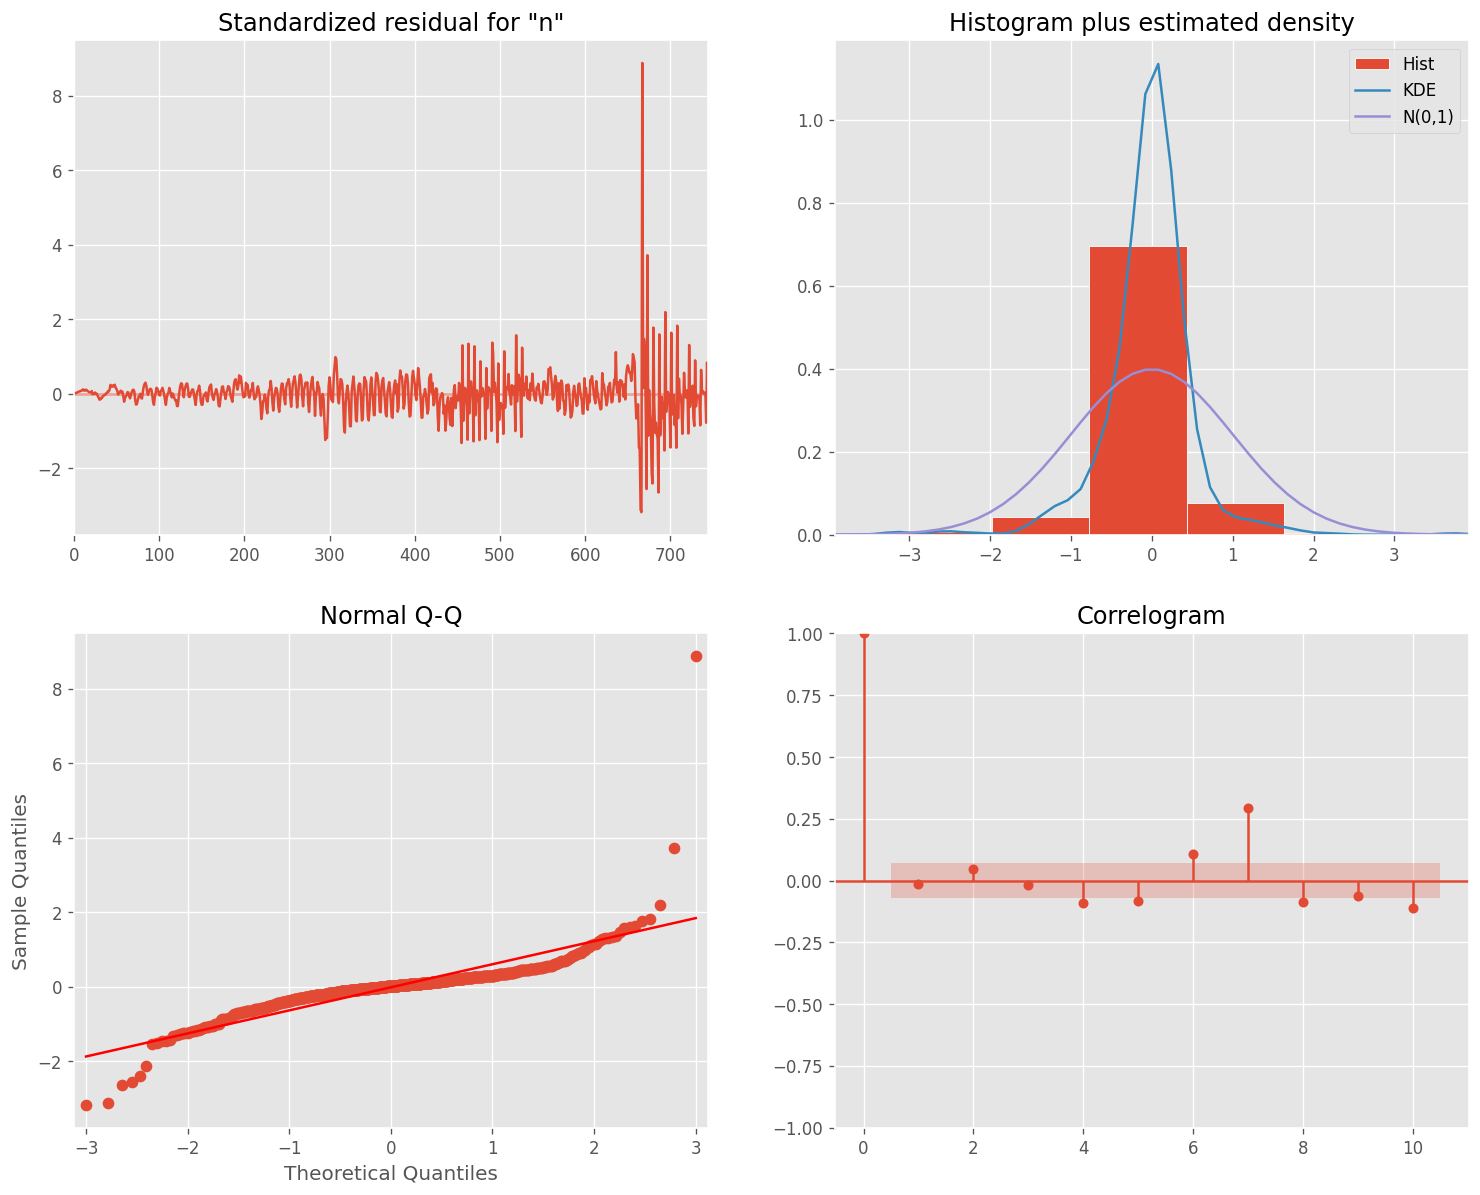

In [28]:
best_model.plot_diagnostics(figsize=(15,12));

c:\Users\prude\OneDrive\Desktop\Project\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\prude\AppData\Local\Temp\ipykernel_34712\3204925124.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Canada['forecast']=best_model.predict(start=10,end=100000,dynamic=True)


<AxesSubplot:>

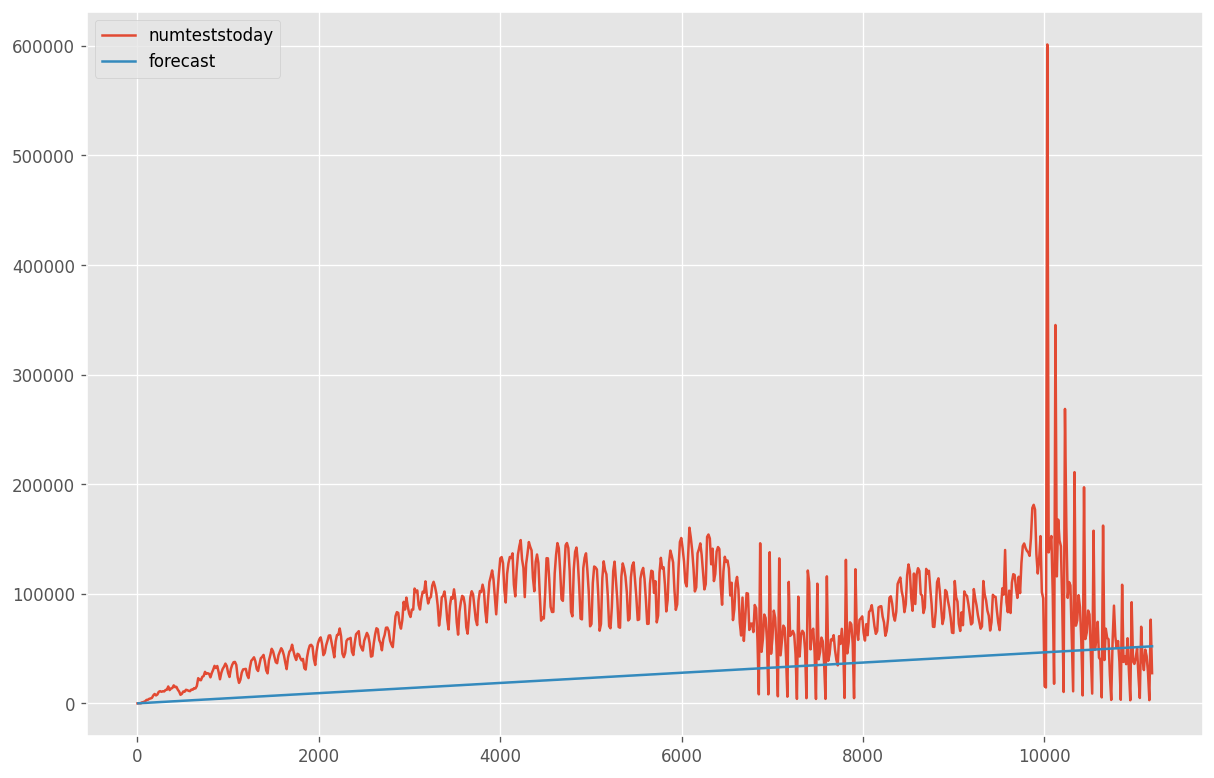

In [48]:
df_Canada['forecast']=best_model.predict(start=10,end=100000,dynamic=True)
df_Canada[['numteststoday','forecast']].plot(figsize=(12,8))

# Future Predictions  <a name="log"></a>

- Forecasting 10 years ahead. Confidence intervals of the forecasted values. Plot the data. Plot the forecasted values. Plot the confidence intervals.

c:\Users\prude\OneDrive\Desktop\Project\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


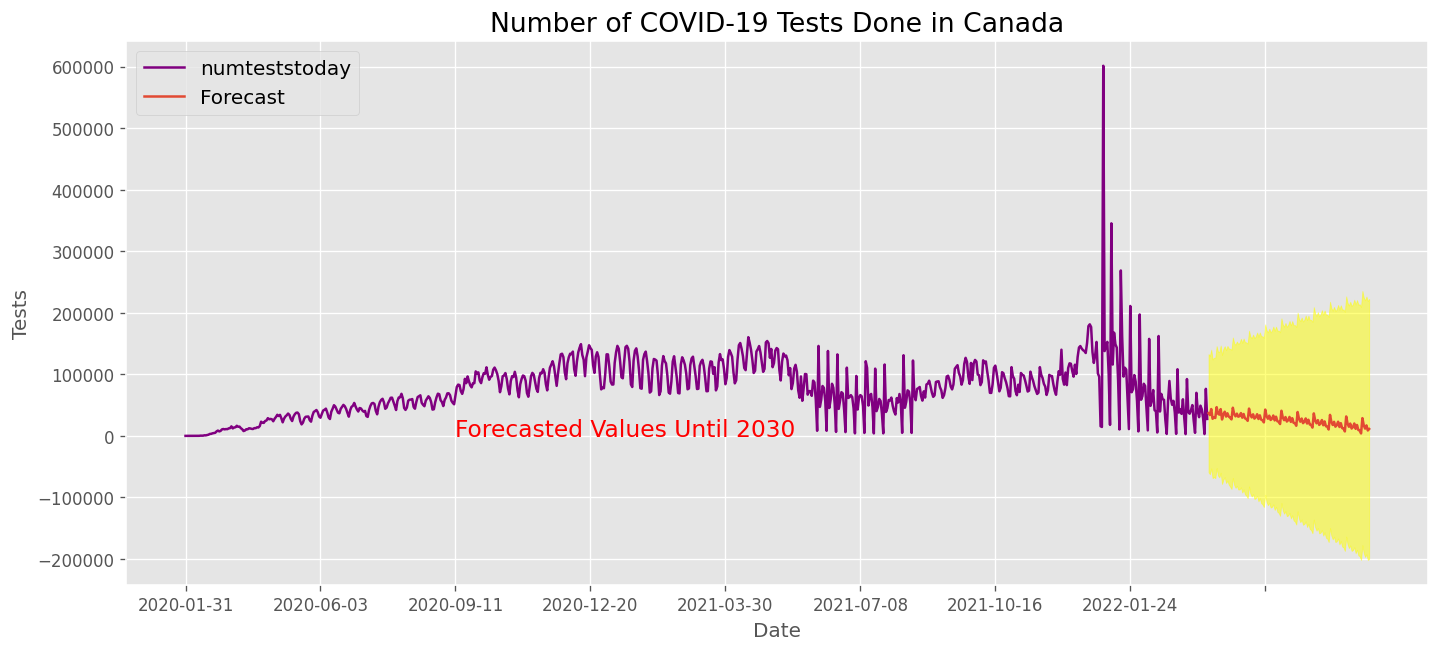

In [49]:
forecast_values = best_model.get_forecast(steps = 120)
forecast_ci = forecast_values.conf_int()
ax = df_Canada.plot(x='date', y='numteststoday', figsize = (14, 6), legend = True, color='purple')
forecast_values.predicted_mean.plot(ax=ax, label='Forecast', figsize = (14, 6), grid=True)
ax.fill_between(forecast_ci.index,
                forecast_ci.iloc[: , 0],
                forecast_ci.iloc[: , 1], color='yellow', alpha = .5)
plt.title('Number of COVID-19 Tests Done in Canada', size = 16)
plt.ylabel('Tests', size=12)
plt.xlabel('Date', size=12)
plt.legend(loc='upper left', prop={'size': 12})
ax.axes.get_xaxis().set_visible(True)

ax.text(200, 200, 'Forecasted Values Until 2030', fontsize=14,  color='red')
plt.show()